In [1]:
## Import necessary libraries 
import cv2
import numpy as np
from scipy.io import loadmat
from scipy import ndimage
import matplotlib.pyplot as plt
from google.colab.patches import cv2_imshow
import copy
import os
%matplotlib inline

In [3]:
# Download Data
if not os.path.exists('/content/part1_images/hotel.seq41.png'):
  !gdown 1fT0H-FbbDZnjMfCJHZcscpcwAXHhGgNw
  !unzip "/content/part1_images.zip" -d "/content/"
  !gdown 1r-Pdino6MRLCEWX_sQOgd8D5AVsRc7Ym

  # Load Initial Key Points
  data = loadmat('/content/initial_keypoints.mat')
  X0 = data['Xo']
  Y0 = data['Yo']

In [4]:
def readImages(folder, num_images):
  arr_images = []
  for i in range(num_images):
    arr_images.append(cv2.imread(f'{folder}hotel.seq{i}.png'))
  return np.array(arr_images, dtype=np.float32)

# read all 51 sequences of images
folder = '/content/part1_images/'
im = readImages(folder, 51)


In [5]:
# compute the 2nd moment matrix 
def moment(im): 
  Ix, Iy=np.gradient(im)
  Ix_sq = np.sum(np.square(Ix))
  Iy_sq = np.sum(np.square(Iy))
  Ix_Iy = np.sum(Ix * Iy)
  M = np.array([[Ix_sq, Ix_Iy], [Ix_Iy, Iy_sq]])
  return Ix, Iy, M

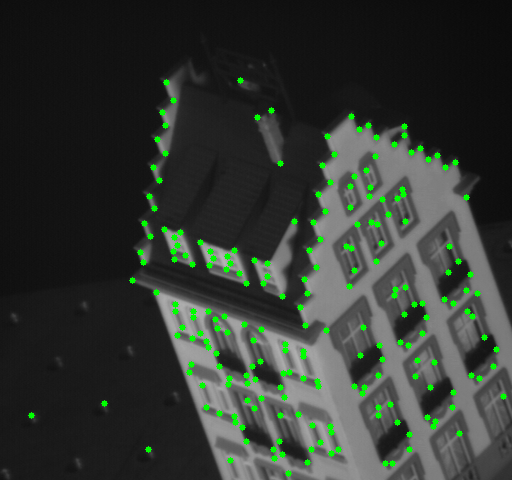

In [6]:
def getKeypoints(img1, tau):
  '''
  Detecting keypoints using Harris corner criterion
  img: input image
  tau: threshold 
  
  output: (N,2) array of [x,y] keypoints (x & y are 0-indexed with upper left pixel of the image being (0,0). i.e, OpenCV frame convention).
  '''
  #Grayscale and blur
  img=img1.copy()
  img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
  img= cv2.GaussianBlur(img, (5,5), 1)
  
  r, c = img.shape
  ws = 5 
  span = ws//2

  C = np.zeros_like(img)

  #slide 5x5 window to obtain gradients, Moment matrix 
  for i in range(span, r-span):
    for j in range(span, c-span):
      patch = img[i-span:i+span, j-span:j+span]
      _, _, M = moment(patch)
      # calculate cornerness for thresholding
      cor = np.linalg.det(M) / np.trace(M)
      if cor>tau * 255: # normalization performed later
        C[i, j] = cor
  C = C/np.amax(C)

  # Non max supression
  r1, c1 = C.shape
  keypoints= []
  for x in range(ws, r1-ws):
    for y in range(ws, c1-ws):
      patch = C[x-ws:x+ws, y-ws:y+ws]
      val, count = np.unique(patch, return_counts=True)
      if count[-1] > 1:
        continue
      if val[-1] == C[x, y]:
         keypoints.append([y, x])

  return keypoints

tau = 0.75
pic=im[0].copy()
key_pts = getKeypoints(pic, tau)

# add plots for the write-up
test_img = im[0].copy()
for key in key_pts:
  result_img = cv2.circle(test_img, (key[0], key[1]), radius=3, color=(0, 255, 0), thickness=-1)
cv2_imshow(result_img)

In [7]:
def getNextPoints(x_key, y_key, im1, im2, ws, valid):
  '''
  Iterative Lucas-Kanade feature tracking
  x,  y : initialized keypoint position in im2
  ws: patch window size

  output: tracked keypoint positions in im2
  '''

  r, c = im1.shape
  thresh=0.7
  x_cord, y_cord=[],[]

  for idx, (x1 ,y1) in enumerate(zip(x_key, y_key)):
    # initialize u,v and next points (x2,y2)
    u = 7
    v = 7
    x2 = copy.copy(x1)
    y2 = copy.copy(y1)
    # print('For:', x1,y1)

    patch = cv2.getRectSubPix(im1, (ws,ws), (x1,y1)) # cv2.getRectSubPix takes care of interpolation
    # Generate gradients and second moment matrix for the ws size (for image1)
    Ix, Iy, M = moment(patch)

    while (u>thresh) and (v>thresh):  # until the change is big enough

      It = cv2.getRectSubPix(im2, (ws,ws), (x2,y2)) - cv2.getRectSubPix(im1, (ws,ws), (x1,y1))
      Ix_It = -(np.sum(Ix*It))
      Iy_It = -(np.sum(Iy*It))
      K = [Ix_It, Iy_It] 
      
      # solve Mx=K (may cause issued when det(M)=0)
      try:
        [u, v] = np.linalg.solve(M, K)
        # print([u, v])
      except np.linalg.LinAlgError as err:
        if 'Singular matrix' in str(err):
          print('problematic det(M)')
          break

      # Update values by adding u and v
      new_x2 = x2 + u
      new_y2 = y2 + v

       # Check if coordinates are within next frame and the update for next iteration
      if new_y2>0 and new_x2>0 and new_y2<r  and new_x2<c:
        x2 = new_x2
        y2 = new_y2
      else:
        valid.append(idx)
        break
        
    x_cord.append(x2)
    y_cord.append(y2)
    # print(len(valid))

  return x_cord, y_cord

In [8]:
def trackPoints(pt_x, pt_y, im, ws, valid):
  '''
  Tracking initial points (pt_x, pt_y) across the image sequence
  Outputs:
    track_x: [Number of keypoints] x [2]
    track_y: [Number of keypoints] x [2]
  '''
  #Dimensions for dummy matrices
  N = np.prod(pt_x.shape)
  tmp = len(im)

  pt_x = pt_x.astype('float32')
  pt_y = pt_y.astype('float32')

  track_x, track_y  = np.zeros((N, tmp)),  np.zeros((N, tmp))

  #save respective cordinates
  track_x[:,0] = pt_x
  track_y[:,0] = pt_y
 
  if len(im.shape) == 4:
    im = im[:, :, :, 0].astype('float32')
  #iterate through finding the next set for point for all 51 images
  for t in range(tmp-1):
    track_x[:, t+1], track_y[:, t+1] = getNextPoints(track_x[:, t], track_y[:, t], im[t,:,:], im[t+1,:,:], ws, valid)

  track_vals= np.concatenate((np.expand_dims(track_x, axis=2), np.expand_dims(track_y, axis=2)), axis=2)
  return track_vals


In [9]:
# track keypoints across the sequences, getNextPoints() is called inside the trackPoints() function

keypoints = copy.copy(np.array(key_pts))
valid_pts=[]
track = trackPoints(pt_x=keypoints[:,0], pt_y=keypoints[:,1], im=im, ws=7, valid=valid_pts)

# Select 20 random coordinates to track
rand_20 = np.random.permutation(np.arange(track.shape[0]))[:20]

# Image 0 for all 3 results
test_img1 = copy.copy(im[0])
test_img2 = copy.copy(im[0])
test_img3 = copy.copy(im[0])

for i in range(track.shape[0]):
  tracked_pt = track[i]
  res_1 = cv2.circle(test_img1, (int(tracked_pt[0][0]), int(tracked_pt[0][1])),2,(0, 255, 0),1)
  res_1 = cv2.circle(test_img1, (int(tracked_pt[1][0]), int(tracked_pt[1][1])),2,(0, 0, 255),-1)
  
  #plot movement of 20 random points
  if i in rand_20:
    for next_pts in tracked_pt:
      res_2 = cv2.circle(test_img2, (int(next_pts[0]), int(next_pts[1])),3,(0, 0, 255),-1)
  
  # plot motion of points going out of frame
  if i in valid_pts:
    for next_pts in tracked_pt:
      res_3 = cv2.circle(test_img3, (int(next_pts[0]), int(next_pts[1])),3, (0, 0, 255),-1)

# cv2_imshow(res_1)
# cv2_imshow(res_2)
# cv2_imshow(res_3)


<img src="https://drive.google.com/uc?id=1h6XXJoIAO-_7g6ghVDlrhnefGkaU48Mv" align="center"/>

<img src="https://drive.google.com/uc?id=1xFfGASoiNDrQJpKbW8_zVZ5kaMG47Og7" align="center"/>

<img src="https://drive.google.com/uc?id=1VcNhPbaQY2yg_x1nnKQX0KHW-TQHFjaK" align="center"/>



